## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy
from scipy import optimize
import requests
import json
import pickle
import seaborn as sns

## Define functions for pulling data

In [2]:
## Defining functions needed only for pulling in data (so not on the website)

def plantower_only(start,end,*nodes):
    full = pd.DataFrame()
    for node in nodes:
        #print(node)
        parameter = 'pm2_5'
        filename="http://128.32.208.8/node/"+node+"/measurements_all/csv?name=Supersite&interval=60&variables="+parameter+"&start="+start+"&end="+end
        data  = pd.read_csv(filename, on_bad_lines="skip",index_col=[0], parse_dates=[0]) 
        data = data.rename(columns={parameter:node})
        data = data.drop(['epoch','node_id','node_file_id','datetime'],axis = 1)
        full = pd.merge(full,data, how = 'outer',left_index=True,right_index=True)
    full = full.reset_index().drop_duplicates("local_timestamp").set_index("local_timestamp")
    return full

def plantower_corr(start,end,*nodes):
    full = pd.DataFrame()
    for node in nodes:
        #print(node)
        parameter = 'pm_pt_corrected'
        filename="http://128.32.208.8/node/"+node+"/measurements_all/csv?name=Supersite&interval=60&variables="+parameter+"&start="+start+"&end="+end
        data  = pd.read_csv(filename, on_bad_lines="skip",index_col=[0], parse_dates=[0]) 
        data = data.rename(columns={parameter:node})
        data = data.drop(['epoch','node_id','node_file_id','datetime'],axis = 1)
        full = pd.merge(full,data, how = 'outer',left_index=True,right_index=True)
    full = full.reset_index().drop_duplicates("local_timestamp").set_index("local_timestamp")
    return full

def RH(start,end,*nodes):
    full = pd.DataFrame()
    for node in nodes:
        #print(node)
        parameter = 'rh'
        filename="http://128.32.208.8/node/"+node+"/measurements_all/csv?name=Supersite&interval=60&variables="+parameter+"&start="+start+"&end="+end
        data  = pd.read_csv(filename, on_bad_lines="skip",index_col=[0], parse_dates=[0]) 
        data = data.rename(columns={parameter:node})
        data = data.drop(['epoch','node_id','node_file_id','datetime'],axis = 1)
        full = pd.merge(full,data, how = 'outer',left_index=True,right_index=True)
    full = full.reset_index().drop_duplicates("local_timestamp").set_index("local_timestamp")
    return full

def epa_import(start,end,*nodes):
    full = pd.DataFrame()
    for node in nodes:
        #print(node)
        parameter = 'pm_25'
        filename="http://128.32.208.8/node/"+node+"/measurements_all/csv?name=Supersite&interval=60&variables="+parameter+"&start="+start+"&end="+end
        data  = pd.read_csv(filename, on_bad_lines="skip",index_col=[0], parse_dates=[0]) 
        data = data.rename(columns={parameter:node})
        data = data.drop(['epoch','node_id','node_file_id','datetime'],axis = 1)
        full = pd.merge(full,data, how = 'outer',left_index=True,right_index=True)
    full = full.reset_index().drop_duplicates("local_timestamp").set_index("local_timestamp")
    return full

def epa_pm_hourly(state,county,site,start,end,*pmvars): 
    ## This is a new pull code with the following changes (see other jupyter notebooks for Pietro's original pull code):
    ## ## the pull URL is now for pulling data by site, not by county
    ## ## the pull function now filters out non-hourly data
    ## ## loop through multiple potential variables
    multi = pd.DataFrame()
    for pmvar in pmvars:
        pmfile = "https://aqs.epa.gov/data/api/sampleData/bySite?email=pievan@berkeley.edu&key=amberswift64&param="+pmvar+"&bdate="+start+"&edate="+end+"&state="+state+"&county="+county+"&site="+site
        # pmfile = "https://aqs.epa.gov/data/api/sampleData/bySite?email=milan_patel@berkeley.edu&key=taupegoose15&param="+pmvar+"&bdate="+start+"&edate="+end+"&state="+state+"&county="+county+"&site="+site
        pmr = requests.get(pmfile) 
        pmdata = json.loads(pmr.text) 
        pmdf = pd.DataFrame(pmdata["Data"])
        pmdf['newtime'] = pd.to_datetime(pmdf["date_local"]+' '+pmdf["time_local"],format='%Y-%m-%d %H:%M')
        pmdf = pmdf.drop(['parameter_code','sample_duration_code','time_local','date_local','method_code','qualifier','method','sample_duration','method_type','cbsa_code','date_of_last_change','state','county','state_code',
                          'poc','datum','parameter','date_gmt','time_gmt','units_of_measure','units_of_measure_code','detection_limit','detection_limit','uncertainty','county_code','site_number','latitude','longitude'],axis = 1)
        pmdf = pmdf.rename(columns = {'sample_measurement':'pm'})
        pmdf = pmdf[pmdf['sample_frequency'] == 'HOURLY']
        multi = pd.concat( [ multi, pmdf[['pm','newtime']] ] )        
    multi = multi.reset_index(drop=True).rename(columns = {'newtime':'local_timestamp', 'pm':'PM_ref'}).set_index('local_timestamp')
    return multi

## Define functions used in the calibration

In [3]:
## Function for determining k and m in the RH Growth Correction Equation
def hygro_fit(X, Y, RH, p0=(0.5,1), print_results=True):
    p_opt, p_cov = scipy.optimize.curve_fit(lambda t,k,m: t*m/(1+k/(100/(RH)-1)),  X,  Y,  p0=p0)
    if print_results:
        print('k = ' + str(round(p_opt[0],4)) + ' ± ' + str(round(np.sqrt(np.diag(p_cov))[0],4)))
        print('m = ' + str(round(p_opt[1],4)) + ' ± ' + str(round(np.sqrt(np.diag(p_cov))[1],4)))
    return p_opt
## X is the raw data, Y is the reference data
## Returns p_opt, where p_opt[0] = k and p_opt[1] = m


## Function for fitting the k and m coefficients to a sine wave with a period set to one year
def sin_fit(X, Y, p0=(0.4, 75, 0.4), print_results=True):
    p_opt, p_cov = scipy.optimize.curve_fit(lambda t,amp, delta, offset: amp * np.sin((2*np.pi/365)*(t - delta)) + offset,  X,  Y,
                                            p0=p0, bounds=([0,0,0],[10,365,10]))
    if print_results:
        print('amp = ' + str(round(p_opt[0],4)) + ' ± ' + str(round(np.sqrt(np.diag(p_cov))[0],4)))
        print('delta = ' + str(round(p_opt[1],4)) + ' ± ' + str(round(np.sqrt(np.diag(p_cov))[1],4)))
        print('offset = ' + str(round(p_opt[2],4)) + ' ± ' + str(round(np.sqrt(np.diag(p_cov))[2],4)))
    return p_opt
## X is the raw data, Y is the reference data
## Returns p_opt, where p_opt[0] = amplitude, p_opt[1] = phase shift, and p_opt[2] = offset


## Function for generating rolling coefficients for the hygroscopic growth parameter and scaling factor, k and m
## Input df must have columns labeled 'pm2_5', 'PM_ref', and 'rh'
def rolling_coef(df, rolling_hours=24*7*4):
    data_fitted = df[['pm2_5','PM_ref','rh']].copy()
    data_fitted['k'] = '' # add columns
    data_fitted['m'] = '' # add columns
    
    for rolled_df in data_fitted.rolling(rolling_hours, min_periods=(rolling_hours-96), center=True):
        rolled_df = rolled_df.dropna()
        if len(rolled_df) >= (rolling_hours - 96):
            the_index = rolled_df.index[round(len(rolled_df)/2)]
            if the_index.hour == 12:
                X = rolled_df['pm2_5']
                Y = rolled_df['PM_ref']
                RH = rolled_df['rh']
                p_opt = hygro_fit(X, Y, RH, p0=(0.5,1), print_results=False)
                k = p_opt[0]
                m = p_opt[1]
                data_fitted.loc[the_index,'k'] = k
                data_fitted.loc[the_index,'m'] = m

    data_fitted['k'] = data_fitted['k'].replace('', np.nan)
    data_fitted['m'] = data_fitted['m'].replace('', np.nan)
    data_fitted = data_fitted.dropna()
    return data_fitted
## Returns a new dataframe with daily coefficients
## Note: the coefficients are generated on hourly data, but only one coefficient is generated for each day (using a 4 week window)
##       so the resulting data frame only has daily data

## Generates the coefficients like the function rolling_coef but takes in three sites as inputs instead
def rolling_coef_3_colocations(df1, df2, df3, rolling_hours=24*7*4):

    df1 = df1.dropna()
    df2 = df2.dropna()
    df3 = df3.dropna()
    
    data_fitted = pd.concat([df1.add_suffix('_df1'),df2.add_suffix('_df2'),df3.add_suffix('_df3')], axis=1, join='outer')
    data_fitted['k'] = '' # add columns
    data_fitted['m'] = '' # add columns
    
    for rolled_df in data_fitted.rolling(rolling_hours, min_periods=(rolling_hours-96), center=True):
        if len(rolled_df) >= (rolling_hours - 96):
            the_index = rolled_df.index[round(len(rolled_df)/2)]
            if the_index.hour == 12: #only regenerating coefficients once per day
                rolled_df_long = pd.wide_to_long(rolled_df.reset_index(), ['pm2_5','rh','PM_ref'], i='local_timestamp', j='site', sep='_', suffix='\w+')
                rolled_df_long = rolled_df_long.dropna()
                X = rolled_df_long['pm2_5']
                Y = rolled_df_long['PM_ref']
                RH = rolled_df_long['rh']
                p_opt = hygro_fit(X, Y, RH, p0=(0.5,1), print_results=False)
                k = p_opt[0]
                m = p_opt[1]
                data_fitted.loc[the_index,'k'] = k
                data_fitted.loc[the_index,'m'] = m

    data_fitted['k'] = data_fitted['k'].replace('', np.nan)
    data_fitted['m'] = data_fitted['m'].replace('', np.nan)
    data_fitted = data_fitted.dropna(subset='k')
    return data_fitted

## Pull in data

In [7]:
LA_data = pd.read_csv("LAData_21_22.csv", on_bad_lines='skip',index_col=[0], parse_dates=[0])

## Generate and Apply Coefficients

In [10]:
## Generate Coefficients
LA_coef = rolling_coef(LA_data)

In [11]:
## Fit Coefficients to Sine Waves

# ## For 2021
# df_21 = LA_coef[LA_coef.index.year == 2021]
# params_k_21 = sin_fit(df_21.index.day_of_year, df_21['k'], p0=(0.4, 75, 0.4), print_results=False)
# params_m_21 = sin_fit(df_21.index.day_of_year, df_21['m'], p0=(0.4, 75, 0.4), print_results=False)

# ## For 2022
# df_22 = LA_coef[LA_coef.index.year == 2022]
# params_k_22 = sin_fit(df_22.index.day_of_year, df_22['k'], p0=(0.4, 75, 0.4), print_results=False)
# params_m_22 = sin_fit(df_22.index.day_of_year, df_22['m'], p0=(0.4, 75, 0.4), print_results=False)

## For 2021 and 2022
df_22 = LA_coef.copy()
params_k_22 = sin_fit(df_22.index.day_of_year, df_22['k'], p0=(0.4, 75, 0.4), print_results=False)
params_m_22 = sin_fit(df_22.index.day_of_year, df_22['m'], p0=(0.4, 75, 0.4), print_results=False)

In [12]:
## This code generates the sinusoidal coefficients for 2021 and 2022 seperately, but due to lack of 2021 data, we wont do this

# LA_corrected = LA_data.copy()

# ## Generate m and k using the sine wave coefficients
# LA_corrected.loc[LA_corrected.index.year == 2021, 'k'] = params_k_21[0] * np.sin((2*np.pi/365)*(LA_corrected[LA_corrected.index.year == 2021].index.day_of_year - params_k_21[1])) + params_k_21[2]
# LA_corrected.loc[LA_corrected.index.year == 2022, 'k'] = params_k_22[0] * np.sin((2*np.pi/365)*(LA_corrected[LA_corrected.index.year == 2022].index.day_of_year - params_k_22[1])) + params_k_22[2]
# LA_corrected.loc[LA_corrected.index.year == 2021, 'm'] = params_m_21[0] * np.sin((2*np.pi/365)*(LA_corrected[LA_corrected.index.year == 2021].index.day_of_year - params_m_21[1])) + params_m_21[2]
# LA_corrected.loc[LA_corrected.index.year == 2022, 'm'] = params_m_22[0] * np.sin((2*np.pi/365)*(LA_corrected[LA_corrected.index.year == 2022].index.day_of_year - params_m_22[1])) + params_m_22[2]

# ## Apply m and k
# LA_corrected['PM_corr'] = LA_corrected['pm2_5'] * LA_corrected['m'] / (1 + LA_corrected['k']/(100/(LA_corrected['rh'])-1))

In [13]:
## Instead we will just propogate the 2022 sine curve backwards

LA_corrected = LA_data.copy()

## Generate m and k using the sine wave coefficients
LA_corrected['k'] = params_k_22[0] * np.sin((2*np.pi/365)*(LA_corrected.index.day_of_year - params_k_22[1])) + params_k_22[2]
LA_corrected['m'] = params_m_22[0] * np.sin((2*np.pi/365)*(LA_corrected.index.day_of_year - params_m_22[1])) + params_m_22[2]

## Apply m and k
LA_corrected['PM_corr'] = LA_corrected['pm2_5'] * LA_corrected['m'] / (1 + LA_corrected['k']/(100/(LA_corrected['rh'])-1))

In [21]:
## Try the EPA Correction
LA_w_EPAcalibration = LA_data.copy()
LA_w_EPAcalibration['PM_corr'] = (0.524*LA_w_EPAcalibration['pm2_5']) - (0.0862*LA_w_EPAcalibration['rh']) + 5.75

## Look at PM Composition in LA

In [18]:
comp = pd.read_csv("LASpeciation.csv", on_bad_lines='skip',index_col=[0], parse_dates=[0])
comp = comp.dropna()
comp_normed = comp.divide(comp['PM2.5 - Local Conditions'], axis=0)

In [19]:
prepped = comp_normed[['Sulfate PM2.5 LC']].dropna()
sulfate_fit = sin_fit(prepped.index.day_of_year, prepped['Sulfate PM2.5 LC'], print_results=False)
prepped = comp_normed[['EC PM2.5 LC TOR']].dropna()
EC_fit = sin_fit(prepped.index.day_of_year, prepped['EC PM2.5 LC TOR'], p0=(0.1, 300, 0.1), print_results=False)

(18628.0, 19358.0)

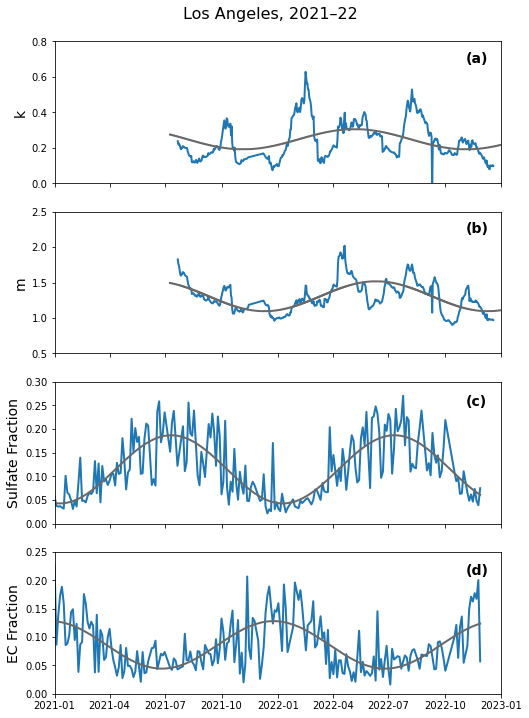

In [20]:
plt.subplots(4,1,figsize=(8,12), sharex=True)
plt.suptitle('Los Angeles, 2021–22', fontsize=16, x=0.5, y=0.92)

plt.subplot(4,1,1)
plt.plot(LA_coef['k'], linewidth=2)
plt.plot(LA_corrected['k'], linewidth=2, color='dimgrey')
plt.ylim(0,0.8)
plt.ylabel('k', fontsize=14)
plt.annotate("(a)", (datetime.datetime(2022,11,5) , 0.68), fontsize=14, fontweight='bold')

plt.subplot(4,1,2)
plt.plot(LA_coef['m'], linewidth=2)
plt.plot(LA_corrected['m'], linewidth=2, color='dimgrey')
plt.ylim(0.5,2.5)
plt.ylabel('m', fontsize=14)
plt.annotate("(b)", (datetime.datetime(2022,11,5) , 2.2), fontsize=14, fontweight='bold')

plt.subplot(4,1,3)
plt.plot(comp_normed[['Sulfate PM2.5 LC']] , linewidth=2)
plt.plot(comp_normed.index, sulfate_fit[0] * np.sin((2*np.pi/365)*(comp_normed.index.day_of_year - sulfate_fit[1])) + sulfate_fit[2] , linewidth=2, color='dimgrey')
plt.ylim(0,0.3)
plt.ylabel('Sulfate Fraction', fontsize=14)
plt.annotate("(c)", (datetime.datetime(2022,11,5) , 0.25), fontsize=14, fontweight='bold')

plt.subplot(4,1,4)
plt.plot(comp_normed[['EC PM2.5 LC TOR']] , linewidth=2)
plt.plot(comp_normed.index, EC_fit[0] * np.sin((2*np.pi/365)*(comp_normed.index.day_of_year - EC_fit[1])) + EC_fit[2] , linewidth=2, color='dimgrey')
plt.ylim(0,0.25)
plt.ylabel('EC Fraction', fontsize=14)
plt.annotate("(d)", (datetime.datetime(2022,11,5) , 0.21), fontsize=14, fontweight='bold')

plt.xlim(datetime.datetime(2021,1,1), datetime.datetime(2023,1,1))

# plt.savefig("/Users/milanp/Desktop/Plantower Paper/Figures/Fig 6.pdf", dpi=300, format='pdf', bbox_inches='tight')

In [25]:
from sklearn.metrics import r2_score

def stats_for_figure_uncorrected(df):
    g = df[['PM_ref', 'pm2_5']].dropna()
    r = g.corr().iloc[0,1]
    r2 = g.corr().iloc[0,1]**2
    R2 = r2_score(g['PM_ref'],g['pm2_5'])
    mean_bias = np.mean(g['pm2_5'] - g['PM_ref'])
    MFB = np.mean(g['pm2_5'] - g['PM_ref'])/g['PM_ref'].mean()
    MNB = ((g['pm2_5'] - g['PM_ref']) / g['PM_ref']).replace([np.NINF, np.Inf],np.nan).mean()
    MAE = np.mean(np.abs(g['pm2_5'] - g['PM_ref']))
    rmse = np.sqrt(mean_squared_error(g['pm2_5'], g['PM_ref']))
    nrmse = np.sqrt(mean_squared_error(g['pm2_5'], g['PM_ref']))/g['PM_ref'].mean()
    IOA = 1 - ( np.sum((g['pm2_5'] - g['PM_ref'])**2) / np.sum( np.abs(g['pm2_5'] - np.mean(g['PM_ref'])) + np.abs(g['PM_ref'] - np.mean(g['pm2_5'])**2) ) )
    return {'r':round(r,3) , 'r2':round(r2,3) , 'R2':round(R2,3) , 'mean bias':round(mean_bias,3) , 'MFB':round(MFB,3) , 'MNB':round(MNB,3), 'MAE':round(MAE,3),
            'rmse':round(rmse,3) , 'nrmse':round(nrmse,3) , 'IOA':round(IOA,3) }

def stats_for_figure_corrected(df):
    g = df[['PM_ref', 'PM_corr']].dropna()
    r = g.corr().iloc[0,1]
    r2 = g.corr().iloc[0,1]**2
    R2 = r2_score(g['PM_ref'],g['PM_corr'])
    mean_bias = np.mean(g['PM_corr'] - g['PM_ref'])
    MFB = np.mean(g['PM_corr'] - g['PM_ref'])/g['PM_ref'].mean()
    MNB = ((g['PM_corr'] - g['PM_ref']) / g['PM_ref']).replace([np.NINF, np.Inf],np.nan).mean()
    MAE = np.mean(np.abs(g['PM_corr'] - g['PM_ref']))
    rmse = np.sqrt(mean_squared_error(g['PM_corr'], g['PM_ref']))
    nrmse = np.sqrt(mean_squared_error(g['PM_corr'], g['PM_ref']))/g['PM_ref'].mean()
    IOA = 1 - ( np.sum((g['PM_corr'] - g['PM_ref'])**2) / np.sum( (np.abs(g['PM_corr'] - np.mean(g['PM_ref'])) + np.abs(g['PM_ref'] - np.mean(g['PM_corr']))**2) ) )
    return {'r':round(r,3) , 'r2':round(r2,3) , 'R2':round(R2,3) , 'mean bias':round(mean_bias,3) , 'MFB':round(MFB,3) , 'MNB':round(MNB,3), 'MAE':round(MAE,3),
            'rmse':round(rmse,3) , 'nrmse':round(nrmse,3) , 'IOA':round(IOA,3) }

In [26]:
LA_residuals = LA_corrected[['rh','PM_ref','pm2_5','PM_corr']].copy()
LA_residuals['residual'] = LA_residuals['pm2_5'] - LA_residuals['PM_ref']
LA_residuals['residual_corr'] = LA_residuals['PM_corr'] - LA_residuals['PM_ref']

In [27]:
LA_residuals_EPAcal = LA_w_EPAcalibration[['rh','PM_ref','pm2_5','PM_corr']].copy()
LA_residuals_EPAcal['residual'] = LA_residuals_EPAcal['pm2_5'] - LA_residuals_EPAcal['PM_ref']
LA_residuals_EPAcal['residual_corr'] = LA_residuals_EPAcal['PM_corr'] - LA_residuals_EPAcal['PM_ref']

''

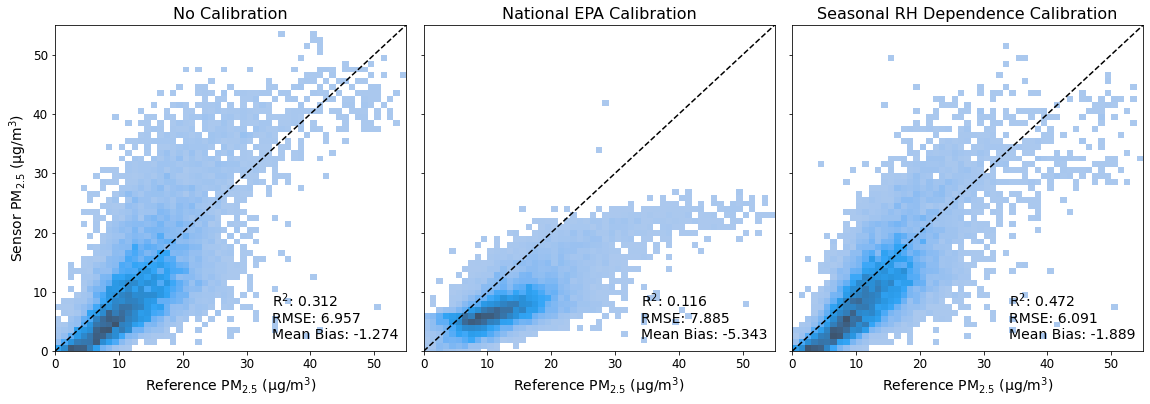

In [28]:
plt.subplots(1,3,figsize=(19.5,6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05)

plt.subplot(1,3,1)
plt.title('No Calibration', fontsize=16)
sns.histplot(data=LA_corrected, x='PM_ref', y='pm2_5', binwidth=1)
plt.plot([0,60],[0,60], color='black', linestyle='dashed')
plt.xlim(0,55)
plt.ylim(0,55)
plt.xlabel('Reference PM$_{2.5}$ (µg/m$^{3}$)', fontsize=14)
plt.ylabel('Sensor PM$_{2.5}$ (µg/m$^{3}$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
stats = stats_for_figure_uncorrected(LA_corrected)
plt.annotate('R$^{2}$: ' + str(stats['R2']) + '\nRMSE: ' + str(stats['rmse']) + '\nMean Bias: ' + str(stats['mean bias']) , (34,2), fontsize=14)

plt.subplot(1,3,2)
plt.title('National EPA Calibration', fontsize=16)
sns.histplot(data=LA_w_EPAcalibration, x='PM_ref', y='PM_corr', binwidth=1).set(ylabel=None)
plt.plot([0,60],[0,60], color='black', linestyle='dashed')
plt.xlabel('Reference PM$_{2.5}$ (µg/m$^{3}$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
stats = stats_for_figure_corrected(LA_w_EPAcalibration)
plt.annotate('R$^{2}$: ' + str(stats['R2']) + '\nRMSE: ' + str(stats['rmse']) + '\nMean Bias: ' + str(stats['mean bias']) , (34,2), fontsize=14)

plt.subplot(1,3,3)
plt.title('Seasonal RH Dependence Calibration', fontsize=16)
sns.histplot(data=LA_corrected, x='PM_ref', y='PM_corr', binwidth=1).set(ylabel=None)
plt.plot([0,60],[0,60], color='black', linestyle='dashed')
plt.xlabel('Reference PM$_{2.5}$ (µg/m$^{3}$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
stats = stats_for_figure_corrected(LA_corrected)
plt.annotate('R$^{2}$: ' + str(stats['R2']) + '\nRMSE: ' + str(stats['rmse']) + '\nMean Bias: ' + str(stats['mean bias']) , (34,2), fontsize=14)
;